<a href="https://colab.research.google.com/github/Zhou-spec/Option_Market_Making/blob/main/option_market_making_policy_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as scistat
from torch.distributions.normal import Normal


class ResidualBlock_Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock_Conv, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet_Conv(nn.Module):
    def __init__(self, m, n, output_size, input_channels, output_channels, num_blocks, final_act):
        super(ResNet_Conv, self).__init__()

        self.fc = nn.Linear(1 + m * n, 1024)
        self.conv1 = nn.Conv1d(input_channels, output_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.final_act = final_act

        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(ResidualBlock_Conv(output_channels, output_channels))

        self.conv2 = nn.Conv1d(output_channels, input_channels, kernel_size=3, stride=1, padding=1)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, output_size)

    def forward(self, t, q):
        q = q.view(-1)
        x = torch.cat((t, q), dim=0)
        out = self.fc(x)
        out = out.unsqueeze(0)
        out = out.unsqueeze(0)
        out = self.conv1(out)
        out = self.relu(out)

        for block in self.blocks:
            out = block(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = out.squeeze()
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = 0.1 * self.final_act(out)


        return out


# this Gaussian policy implementation is for the actor-critic algorithm
# modeling the mean of bid-ask policy as a neural network directly
def Gaussian_Policy(net, t, q, A, B, gamma):
    number = A.shape[0] * A.shape[1]
    mean = net.forward(t, q) # the output for the neural network is of dim 2*m*n
    bid_mean = mean[:number]
    ask_mean = mean[number:]
    variance = (gamma / (2 * B)).view(-1)
    std = torch.sqrt(variance)
    bid_matrix = torch.normal(bid_mean, std).view(A.shape)
    ask_matrix = torch.normal(ask_mean, std).view(A.shape)

    return bid_matrix, ask_matrix

def Gaussian_Policy_Iteration(net, t, q, A, B, gamma):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    bid_matrix  = torch.zeros(q.shape).to(device)
    ask_matrix  = torch.zeros(q.shape).to(device)

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            x = torch.zeros(q.shape).to(device)
            x[i, j] = 1
            mean_bid = A[i, j] / (2 * B[i, j]) + 0.5 * (net.forward(t, q) - net.forward(t, q + x))
            mean_ask = A[i, j] / (2 * B[i, j]) + 0.5 * (net.forward(t, q) - net.forward(t, q - x))
            variance = gamma / (2 * B[i, j])
            std = torch.sqrt(variance)
            bid_matrix[i, j] = torch.normal(mean_bid, std)
            ask_matrix[i, j] = torch.normal(mean_ask, std)

    return bid_matrix, ask_matrix



def Stock_Prices_Simulation(T, dt, mu, sigma, S0):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    S = torch.zeros(N).to(device)
    S[0] = S0
    for count in range(N - 1):
        S[count + 1] = S[count] + mu * S[count] * dt + sigma * S[count] * torch.sqrt(dt) * torch.normal(0.0, 1.0, size=(1,)).to(device)
    return S


def Market_Order_Simulation(dt, A, B, bid_matrix, ask_matrix):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    orders = torch.zeros(bid_matrix.shape).to(device)
    buy_orders = torch.zeros(bid_matrix.shape).to(device)
    sell_orders = torch.zeros(bid_matrix.shape).to(device)
    m = bid_matrix.shape[0]
    n = bid_matrix.shape[1]
    for i in range(m):
        for j in range(n):
            intensity_bid = A[i, j] - B[i, j] * bid_matrix[i, j]
            intensity_ask = A[i, j] - B[i, j] * ask_matrix[i, j]
            buy_orders[i, j] = torch.poisson(intensity_bid * dt)
            sell_orders[i, j] = torch.poisson(intensity_ask * dt)
            orders[i, j] = buy_orders[i, j] - sell_orders[i, j]

    return orders, buy_orders, sell_orders


def Train_Data_Simulation(T, dt, A, B, gamma, net):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    m = A.shape[0]
    n = A.shape[1]
    q = torch.zeros((N, m, n)).to(device)
    buy = torch.zeros((N, m, n)).to(device)
    sell = torch.zeros((N, m, n)).to(device)
    bid = torch.zeros((N, m, n)).to(device)
    ask = torch.zeros((N, m, n)).to(device)

    for count in range(N - 1):
        t = count * dt
        bid_matrix, ask_matrix = Gaussian_Policy(net, t, q[count], A, B, gamma)
        orders, buy_orders, sell_orders = Market_Order_Simulation(dt, A, B, bid_matrix, ask_matrix)
        buy[count] = buy_orders
        sell[count] = sell_orders
        q[count + 1] = q[count] + orders
        bid[count] = bid_matrix
        ask[count] = ask_matrix

    return q, buy, sell, bid, ask


def Train_Data_Simulation_Iteration(T, dt, A, B, gamma, net):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    m = A.shape[0]
    n = A.shape[1]
    q = torch.zeros((N, m, n)).to(device)
    buy = torch.zeros((N, m, n)).to(device)
    sell = torch.zeros((N, m, n)).to(device)
    bid = torch.zeros((N, m, n)).to(device)
    ask = torch.zeros((N, m, n)).to(device)

    for count in range(N - 1):
        t = count * dt
        bid_matrix, ask_matrix = Gaussian_Policy_Iteration(net, t, q[count], A, B, gamma)
        orders, buy_orders, sell_orders = Market_Order_Simulation(dt, A, B, bid_matrix, ask_matrix)
        buy[count] = buy_orders
        sell[count] = sell_orders
        q[count + 1] = q[count] + orders
        bid[count] = bid_matrix
        ask[count] = ask_matrix

    return q, buy, sell, bid, ask


#the following are option greeks' functions
def d1(S, K, r, sigma, T):
    return (torch.log(S/K) + (r+sigma*sigma/2)*T)/(sigma*math.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma*torch.sqrt(T)

def Gamma(S, K, r, sigma, T):
    # use torch module to get teh pdf of normal distribution
    normal_dist = Normal(0, 1)
    return normal_dist.log_prob(d1(S, K, r, sigma, T)).exp() /(S*sigma*torch.sqrt(T))

def Theta(S, K, r, sigma, T):
    normal_dist = Normal(0, 1)
    aux1 = -S * normal_dist.log_prob(d1(S, K, r, sigma, T)).exp() * sigma / (2*torch.sqrt(T))
    aux2 = -r*K*torch.exp(-r*T)*normal_dist.cdf(d2(S, K, r, sigma, T))
    return aux1+aux2

# here, the S will be trace of the stock price
def Options_Theta(Vol_surface, S, r, T, dt, Maturities, Strikes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    m = Vol_surface.shape[0]
    n = Vol_surface.shape[1]
    theta = torch.zeros((N, m, n)).to(device)
    for count in range(N):
        t = count * dt
        for i in range(m):
            for j in range(n):
                theta[count][i][j] = Theta(S[count], Strikes[i], r, Vol_surface[i][j], Maturities[j] - t)
    return theta

# here, the S will be trace of the stock price
def Options_Gamma(Vol_surface, S, r, T, dt, Maturities, Strikes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    m = Vol_surface.shape[0]
    n = Vol_surface.shape[1]
    gamma = torch.zeros((N, m, n)).to(device)
    for count in range(N):
        t = count * dt
        for i in range(m):
            for j in range(n):
                gamma[count][i][j] = Gamma(S[count], Strikes[i], r, Vol_surface[i][j], Maturities[j] - t)
    return gamma


# call option price function with S, K, T, r, sigma
def call_option_price(S, K, T, r, sigma):
    d1 = (torch.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * torch.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)
    return S * torch.distributions.normal.Normal(0, 1).cdf(d1) - K * torch.exp(-r * T) * torch.distributions.normal.Normal(0, 1).cdf(d2)


def final_return(buy, sell, bid, ask, T, dt, Vol_surface, S, r, Maturities, Strikes):
    N = int(T / dt)
    profit = 0
    profit += torch.sum(buy * bid + sell * ask)
    profit += (torch.sum((Options_Theta(Vol_surface, S, r, T, dt, Maturities, Strikes) + 0.5 * Options_Gamma(Vol_surface, S, r, T, dt, Maturities, Strikes)) * q) * dt).item()

    return profit.item()


In [ ]:
def option_loss(Vol_surface, S, q, Strikes, Maturities, r, T, dt):
    N = int(T / dt)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss = torch.zeros(N).to(device)
    for count in range(N):
        t = count * dt
        loss[count] =  torch.sum((Options_Theta(Vol_surface, S, r, T, dt, Maturities, Strikes)[count] + 0.5 * Options_Gamma(Vol_surface, S, r, T, dt, Maturities, Strikes)[count]) * q[count])
    return loss


def inventory_loss(A, B, q, buy, sell, net, T, dt):
    N = int(T / dt)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    m = A.shape[0]
    n = A.shape[1]
    loss = torch.zeros(N).to(device)
    for count in range(N):
        t = count * dt
        loss1 = torch.sum((A / (2 * B)) * (buy[count] + sell[count])) + 0.5 * net.forward(t, q[count]) * torch.sum(buy[count] + sell[count])
        loss2 = 0
        for i in range(m):
            for j in range(n):
                x = torch.zeros((m, n)).to(device)
                x[i, j] = 1
                loss2 += net.forward(t, q[count] + x) * buy[count, i, j] + net.forward(t, q[count] - x) * sell[count, i, j]
        loss[count] = loss1 - loss2

    return loss

def value_function_loss(T, dt, q, net):
    N = int(T / dt)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss = torch.zeros(N).to(device)
    for count in range(N - 1):
        t = count * dt
        loss[count] = (net.forward(t + dt, q[count + 1]) - net.forward(t, q[count])) / dt
    return loss


def constant_loss(gamma, B, T, dt):
    N = int(T / dt)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    m = B.shape[0]
    n = B.shape[1]
    loss = torch.zeros(N).to(device)
    for count in range(N):
        loss[count] = gamma * ((m * n * 1.79817986835) + torch.sum(torch.log(gamma / (2 * B))))
    return loss

def total_loss(Vol_surface, S, q, Strikes, Maturities, r, T, dt, A, B, buy, sell, net, gamma):
    loss1 = option_loss(Vol_surface, S, q, Strikes, Maturities, r, T, dt)[:-1]
    loss2 = inventory_loss(A, B, q, buy, sell, net, T, dt)[: -1]
    loss3 = value_function_loss(T, dt, q, net)[:-1]
    loss4 = constant_loss(gamma, B, T, dt)[:-1]
    loss = 0.5 * dt * dt * torch.sum((loss1 + loss2 + loss3 - loss4)**2)
    return loss


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
A = torch.tensor([[36, 34, 32, 30], [46, 44, 42, 40], [56, 54, 52, 50], [46, 44, 42, 40], [36, 34, 32, 30]]).to(device)
B = torch.tensor([[3, 3, 3, 3], [4, 4, 4, 4], [5, 5, 5, 5], [4, 4, 4, 4], [3, 3, 3, 3]]).to(device)
gamma = torch.tensor([0.1]).to(device)
T = torch.tensor([1]).to(device)
dt = torch.tensor([0.1]).to(device)
mu = torch.tensor([0.0]).to(device)
sigma = torch.tensor([0.05]).to(device)
S0 = torch.tensor([100.0]).to(device)
m = 5
n = 4
Vol_surface = torch.tensor([[0.2, 0.2, 0.18, 0.18], [0.14, 0.14, 0.12, 0.12], [0.1, 0.1, 0.08, 0.08], [0.14, 0.14, 0.12, 0.12], [0.2, 0.2, 0.18, 0.18]]).to(device)
Strikes = torch.tensor([90, 95, 100, 105, 110]).to(device) # means i in the code
Maturities = torch.tensor([2, 3, 4, 5]).to(device) # means j in the code
r = torch.tensor([0]).to(device)

policy_net = ResNet_Conv(m, n, 2 * m * n, 1, 1, 2, nn.Sigmoid()).to(device)
value_net = ResNet_Conv(m, n, 1, 1, 1, 2, nn.Identity()).to(device)

In [ ]:
optimizer = torch.optim.Adam(value_net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

data = []
stock = []
final_returns_collections = []
loss_collection = []

for _ in range(50):
    q, buy, sell, bid, ask = Train_Data_Simulation(T, dt, A, B, gamma, policy_net)
    data.append([q, buy, sell, bid, ask])
    S = Stock_Prices_Simulation(T, dt, mu, sigma, S0)
    stock.append(S)

loss_sub_collection = []
for epoch in range(30):
    print('epoch: ', epoch)
    optimizer.zero_grad()
    q, buy, sell, bid, ask = data[np.random.randint(0,50)]
    S = stock[0]
    loss = total_loss(Vol_surface, S, q, Strikes, Maturities, r, T, dt, A, B, buy, sell, value_net, gamma)
    loss_sub_collection.append(loss.item())
    print(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()

loss_collection.append(loss_sub_collection)

epoch:  0
33123.98046875
epoch:  1
31733.876953125
epoch:  2
18756.91015625
epoch:  3
1232.2445068359375
epoch:  4
16306.8291015625
epoch:  5
623.1213989257812
epoch:  6
11844.888671875
epoch:  7
11181.400390625
epoch:  8
14939.0234375
epoch:  9
8128.091796875
epoch:  10
7067.08056640625
epoch:  11
1021.8145751953125
epoch:  12
1896.79345703125
epoch:  13
1707.4052734375
epoch:  14
385.3260803222656
epoch:  15
24168.392578125
epoch:  16
2950.821533203125
epoch:  17
4290.78955078125
epoch:  18
16089.8115234375
epoch:  19
10064.68359375
epoch:  20
9103.580078125
epoch:  21
5846.3935546875
epoch:  22
7994.5322265625
epoch:  23
2638.518310546875
epoch:  24
628.3381958007812
epoch:  25
619.9981079101562
epoch:  26
7571.134765625
epoch:  27
1814.9381103515625
epoch:  28
1840.2645263671875
epoch:  29
407.06829833984375


In [ ]:
policy_net = value_net
value_net = ResNet_Conv(m, n, 1, 1, 1, 2, nn.Identity()).to(device)

for iteration in range(5):
    optimizer = torch.optim.Adam(value_net.parameters(), lr=0.05)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

    new_data = []
    new_stock = []
    new_return = []
    loss_sub_collection = []
    for _ in range(100):
        q, buy, sell, bid, ask = Train_Data_Simulation_Iteration(T, dt, A, B, gamma, policy_net)
        S = Stock_Prices_Simulation(T, dt, mu, sigma, S0)
        new_data.append([q, buy, sell, bid, ask])
        new_stock.append(S)
        print(final_return(buy, sell, bid, ask, T, dt, Vol_surface, S, r, Maturities, Strikes))
        f_return = final_return(buy, sell, bid, ask, T, dt,  Vol_surface, S, r, Maturities, Strikes)
        new_return.append(f_return)

    final_returns_collections.append(new_return)

    for epoch in range(20):
        print('epoch: ', epoch)
        optimizer.zero_grad()
        q, buy, sell, bid, ask = new_data[np.random.randint(0,50)]
        S = new_stock[np.random.randint(0,50)]
        loss = total_loss(Vol_surface, S, q, Strikes, Maturities, r, T, dt, A, B, buy, sell, value_net, gamma)
        print(loss.item())
        loss_sub_collection.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step()

    loss_collection.append(loss_sub_collection)

    policy_net = value_net
    value_net = ResNet_Conv(m, n, 1, 1, 1, 2, nn.Sigmoid()).to(device)


4052.15771484375
4087.92724609375
4090.820068359375
3932.255126953125
3797.285400390625
4088.403076171875
4124.18359375
3751.1748046875
3946.86083984375
3888.697998046875
4155.509765625
4091.525634765625
3931.225341796875
3865.453857421875
3922.218017578125
4064.380859375
4057.394775390625
4233.93115234375
4157.30810546875
3852.085205078125
4201.64208984375
3943.855712890625
3853.37890625
3924.289794921875
3929.5224609375
3833.846435546875
3980.168212890625
3921.028564453125
4160.3798828125
3850.2578125
3939.8505859375
4038.227783203125
3976.00390625
3930.40673828125
3721.07373046875
3899.31298828125
3661.8203125
3916.30078125
4016.005126953125
3883.39794921875
4154.7734375
4014.9287109375
3889.5751953125
4049.453125
3591.5302734375
3999.328369140625
3968.267578125
3799.298095703125
4330.2890625
3953.89013671875
4170.1591796875
4008.1376953125
4269.92626953125
3916.554443359375
3782.79931640625
3810.82861328125
3864.377685546875
3831.887451171875
4074.03662109375
4135.13525390625
3883.

KeyboardInterrupt: ignored

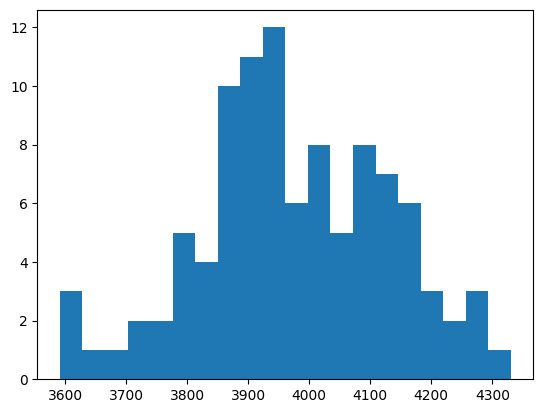

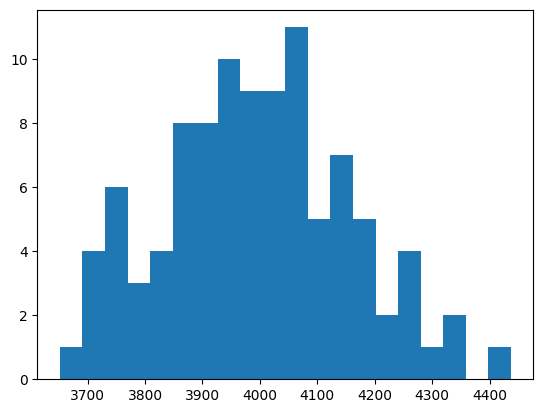

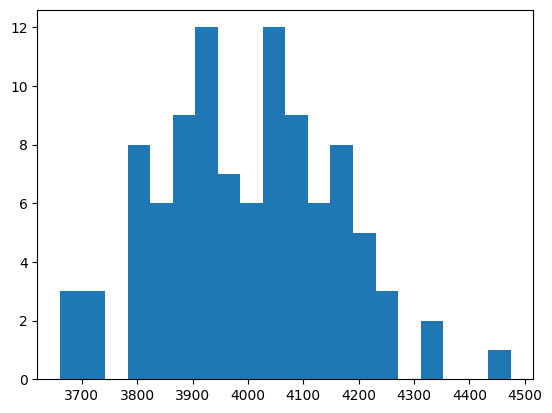

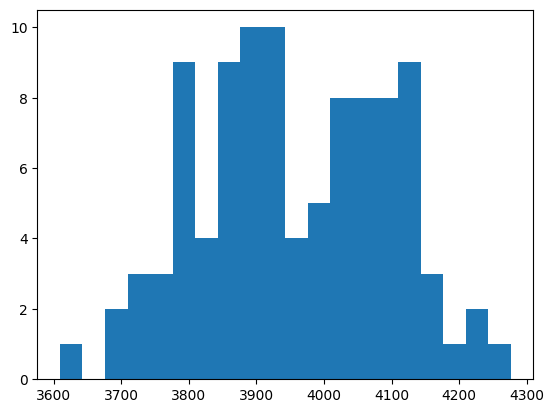

In [ ]:
for _ in range(len(final_returns_collections)):
  f = final_returns_collections[_]
  plt.figure()
  plt.hist(f, bins = 20)
  plt.show()

In [ ]:
final = np.array(final_returns_collections)
np.save('final_returns_policy_iteration.npy', final)

In [ ]:
q1 = torch.tensor([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]).to(device)
q2 = torch.tensor([[3 * abs(2 - i) + j for j in range(4)] for i in range(5)]).to(device)
q3 = torch.tensor([[3, 4, -5, -6], [1, 2, -3, -4], [0, 1, -1, 1], [1, -2, 3, 4], [2, -3, 4, 5]]).to(device)
inventory = torch.zeros(3, 5, 4).to(device)
inventory[0] = q1
inventory[1] = q2
inventory[2] = q3


bid_ask_first = Gaussian_Policy_Iteration(policy_net, torch.tensor([0.0]).to(device), q1, A, B, gamma)
bid_ask_second = Gaussian_Policy_Iteration(policy_net, torch.tensor([0.5]).to(device), q2, A, B, gamma)
bid_ask_third = Gaussian_Policy_Iteration(policy_net, torch.tensor([0.0]).to(device), q3, A, B, gamma)

print(bid_ask_first)

(tensor([[5.7780, 5.6405, 5.3036, 4.9611],
        [5.6964, 5.6265, 5.2456, 5.1175],
        [5.6140, 5.4583, 5.1519, 5.0625],
        [5.5988, 5.3314, 5.3161, 4.8431],
        [6.0366, 5.4950, 5.2950, 4.7647]], device='cuda:0',
       grad_fn=<CopySlices>), tensor([[6.0221, 5.8679, 5.4678, 5.1010],
        [5.8412, 5.5327, 5.4039, 4.8862],
        [5.5051, 5.4906, 5.1388, 4.8954],
        [5.8497, 5.6176, 5.1609, 4.9263],
        [5.8750, 5.6268, 5.4269, 5.0835]], device='cuda:0',
       grad_fn=<CopySlices>))


In [ ]:
b = bid_ask_first[0].cpu().detach().numpy()
b

array([[5.7780337, 5.640519 , 5.303635 , 4.961148 ],
       [5.696408 , 5.626494 , 5.2455525, 5.117471 ],
       [5.613976 , 5.458295 , 5.151904 , 5.0624757],
       [5.5987897, 5.33142  , 5.316056 , 4.843122 ],
       [6.0365753, 5.4949784, 5.294994 , 4.7647133]], dtype=float32)

In [ ]:
bid_matrix = np.array([bid_ask_first[0].cpu().detach().numpy(), bid_ask_second[0].cpu().detach().numpy(), bid_ask_third[0].cpu().detach().numpy()])
ask_matrix = np.array([bid_ask_first[1].cpu().detach().numpy(), bid_ask_second[1].cpu().detach().numpy(), bid_ask_third[1].cpu().detach().numpy()])
np.save('bid_matrix_policy_iteration.npy', bid_matrix)
np.save('ask_matrix_policy_iteration.npy', ask_matrix)